# author: Levon Abramian, J4132
# Task 6. Algorithms on graphs. Path search algorithms on weighted graphs

### The use of path search algorithms on weighted graphs (Dijkstra's, A* and BellmanFord algorithms)

In [1]:
import functools
import heapq
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import time


from dataclasses import dataclass
from random import randint
from scipy import stats
from tqdm.notebook import tqdm

In [2]:
VERT_N = 100
EDGE_N = 500

MIN_WEIGHT = 1
MAX_WEIGHT = 1000

INFINITY = 1e8

In [3]:
GRID_WIDTH = 20
GRID_HEIGHT = 10
NUM_OBSTACLES = 40

DIRECTIONS = [(0, 1), (1, 0), (0, -1), (-1, 0)]

In [4]:
def time_elapsed(n=10):
    def decorator_time_elapsed(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            total_time = 0
            for _ in range(n):
                start_time = time.perf_counter()
                result = func(*args, **kwargs)
                end_time = time.perf_counter()
                total_time += (end_time - start_time)
            
            avg_time = total_time / n
            return result, avg_time
        return wrapper
    return decorator_time_elapsed

In [5]:
def generate_adjacency_matrix(num_verts, num_edges):
    adj_matrix = [[0
                   for _ in range(num_verts)]
                      for _ in range(num_verts)]
    current_edges_num = 0

    while current_edges_num < num_edges:
        v = randint(0, num_verts - 1)
        u = randint(0, num_verts - 1)

        if u != v and adj_matrix[u][v] == 0:
            weight = randint(MIN_WEIGHT, MAX_WEIGHT)
            adj_matrix[v][u] = weight
            adj_matrix[u][v] = weight
            current_edges_num += 1
    
    return adj_matrix

In [6]:
@dataclass
class Pair:
    to: int
    weight: int

def adj_matrix_to_adj_lst(adjacency_matrix):
    n = len(adjacency_matrix)
    adjacency_list = [[Pair(j, adjacency_matrix[i][j])
                           for j in range(n) if adjacency_matrix[i][j] != 0]
                              for i in range(n)]
    return adjacency_list

In [7]:
def relax(vertex: int, adj_matrix, distance):
    for i in range(len(adj_matrix)):
        d = adj_matrix[vertex][i]
            
        if d <= 0:
            continue
            
        if distance[vertex] + d < distance[i]:
            distance[i] = distance[vertex] + d 

@time_elapsed(n=10)
def dijkstra(start: int, adj_matrix):
    distance = [INFINITY] * VERT_N
    used = [False] * VERT_N
    
    distance[start] = 0
    used[start] = True
        
    relax(start, adj_matrix, distance)
        
    while True:
        min_dist = INFINITY
        new_vertex = -1

        for i in range(len(adj_matrix)):
            if not used[i] and distance[i] < min_dist:
                min_dist = distance[i]
                new_vertex = i
        
        if new_vertex == -1:
            break
        
        relax(new_vertex, adj_matrix, distance)
        used[new_vertex] = True
    return distance

In [8]:
@time_elapsed(n=10)
def bellman_ford(start, adj_list):
    size = len(adj_list)
    preds = [-1] * size
    used = [False] * size
    distance = [INFINITY] * size
    
    queue = [start]
    used[start] = True
    distance[start] = 0
    
    while queue:
        current_vertex = queue.pop()
        used[current_vertex] = False
        
        for pair in adj_list[current_vertex]:
            new_distance = distance[current_vertex] + pair.weight; 
            
            if new_distance < distance[pair.to]:
                distance[pair.to] = new_distance
                preds[pair.to] = current_vertex
                if not used[pair.to]:
                    queue.append(pair.to)
    return distance

In [9]:
def visualize_graph(adjacency_matrix):
    adj_matrix = np.asmatrix(adjacency_matrix)
    G = nx.from_numpy_array(adj_matrix)

    components = list(nx.connected_components(G))
    print(len(components))
    colors = plt.get_cmap('cool', len(components))

    plt.figure(figsize=(12, 12))
    
    for idx, component in enumerate(components):
        subgraph = G.subgraph(component)
        pos = nx.spring_layout(subgraph)
        nx.draw_networkx_nodes(subgraph, pos, node_size=80, node_color=[colors(idx)])
        nx.draw_networkx_edges(subgraph, pos)
        nx.draw_networkx_labels(subgraph, pos, font_size=10)

In [10]:
def a_star(start, goal, grid):
    open_set = []
    heapq.heappush(open_set, (0, start))
    
    came_from = {}
    g_score = {cell: float('inf') for cell in np.ndindex(grid.shape)}
    g_score[start] = 0
    
    f_score = {cell: float('inf') for cell in np.ndindex(grid.shape)}
    f_score[start] = heuristic(start, goal)

    searched_cells = set()
    
    while open_set:
        current = heapq.heappop(open_set)[1]
        searched_cells.add(current)
        
        if current == goal:
            return reconstruct_path(came_from, current), searched_cells
        
        for direction in DIRECTIONS:
            neighbor = (current[0] + direction[0], current[1] + direction[1])
            if 0 <= neighbor[0] < grid.shape[0] and 0 <= neighbor[1] < grid.shape[1]:
                if grid[neighbor] == 0:
                    tentative_g_score = g_score[current] + 1
                    
                    if tentative_g_score < g_score[neighbor]:
                        came_from[neighbor] = current
                        g_score[neighbor] = tentative_g_score
                        f_score[neighbor] = g_score[neighbor] + heuristic(neighbor, goal)
                        if neighbor not in [i[1] for i in open_set]:
                            heapq.heappush(open_set, (f_score[neighbor], neighbor))
    
    return None, searched_cells


def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])


def reconstruct_path(came_from, current):
    total_path = [current]
    while current in came_from:
        current = came_from[current]
        total_path.append(current)
    return total_path[::-1]


In [11]:
def create_grid(width, height, num_obstacles):
    grid = np.zeros((height, width), dtype=int)
    obstacles = 0

    while obstacles < num_obstacles:
        x = random.randint(0, height - 1)
        y = random.randint(0, width - 1)
        if grid[x, y] == 0:
            grid[x, y] = 1
            obstacles += 1

    return grid


def plot_grid(grid, path=None, searched_cells=None, start=None, goal=None):
    fig, ax = plt.subplots(figsize=(10, 5))

    for (i, j), value in np.ndenumerate(grid):
        color = 'white' if value == 0 else 'black'
        ax.add_patch(plt.Rectangle((j, i), 1, 1, facecolor=color))

    if searched_cells:
        for (x, y) in searched_cells:
            ax.add_patch(plt.Rectangle((y, x), 1, 1, facecolor='blue', alpha=0.5))
    
    if path:
        for (x, y) in path:

            ax.add_patch(plt.Rectangle((y, x), 1, 1, facecolor='red'))

    if start:
        ax.add_patch(plt.Rectangle((start[1], start[0]), 1, 1, facecolor='green'))
    if goal:
        ax.add_patch(plt.Rectangle((goal[1], goal[0]), 1, 1, facecolor='orange'))

    plt.xlim(0, GRID_WIDTH)
    plt.ylim(GRID_HEIGHT, 0)
    
   
    plt.xticks(range(GRID_WIDTH))
    plt.yticks(range(GRID_HEIGHT)) 
    for tick in ax.get_xticklabels():
        tick.set_horizontalalignment('center') 
        tick.set_x(tick.get_position()[0] + 0.5)

    for tick in ax.get_yticklabels():
        tick.set_verticalalignment('center')
        tick.set_y(tick.get_position()[1] + 0.5)

    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    
    plt.grid(True)
    plt.title('A* Pathfinding Visualization')
   
    plt.show()

### FIRST PART

In [12]:
adj_matrix = generate_adjacency_matrix(VERT_N, EDGE_N)
adj_list = adj_matrix_to_adj_lst(adj_matrix)

1


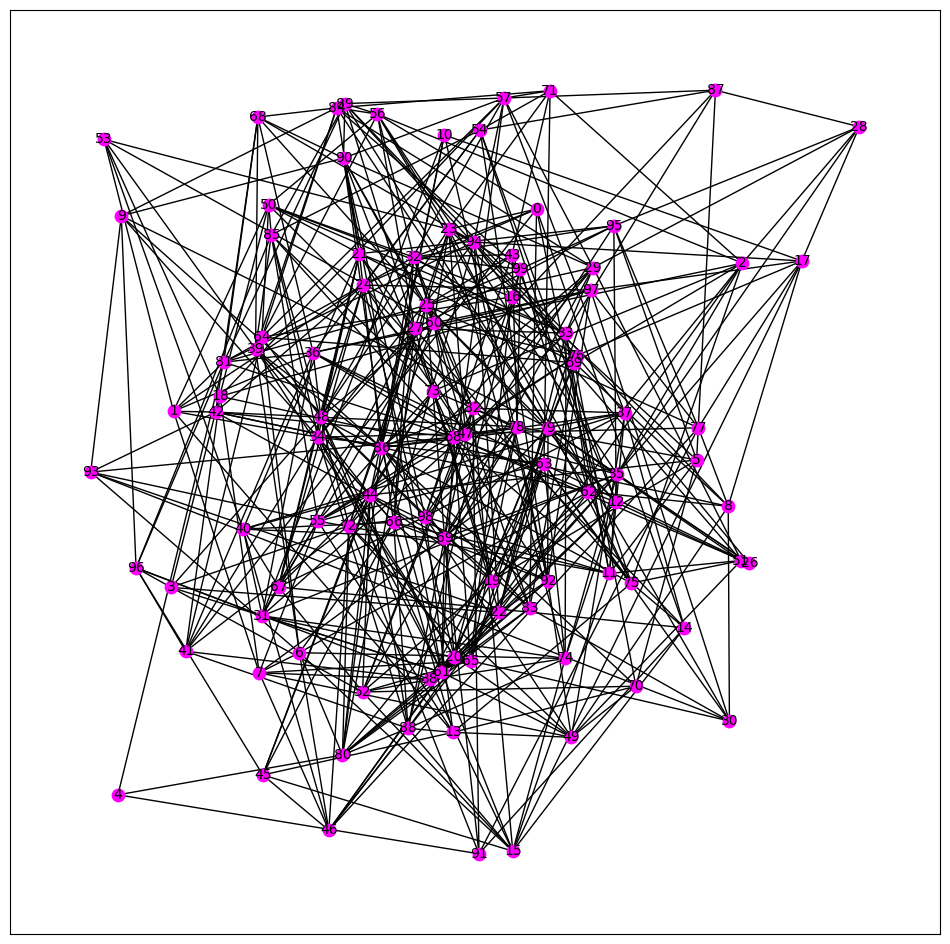

In [13]:
visualize_graph(adj_matrix)

In [14]:
dijkstra_avg_times = []
bellman_ford_avg_times = []
for _ in tqdm(range(100)):
    source_vertex = randint(0, VERT_N - 1)
    dijkstra_distances, dijkstra_avg_time = dijkstra(source_vertex, adj_matrix)
    bellman_ford_distances, bellman_ford_avg_time = bellman_ford(source_vertex, adj_list)

    if dijkstra_distances != bellman_ford_distances:
        print('Error')
        print(adj_matrix)
        print(adj_list)
        break
    dijkstra_avg_times.append(dijkstra_avg_time)
    bellman_ford_avg_times.append(bellman_ford_avg_time)

  0%|          | 0/100 [00:00<?, ?it/s]

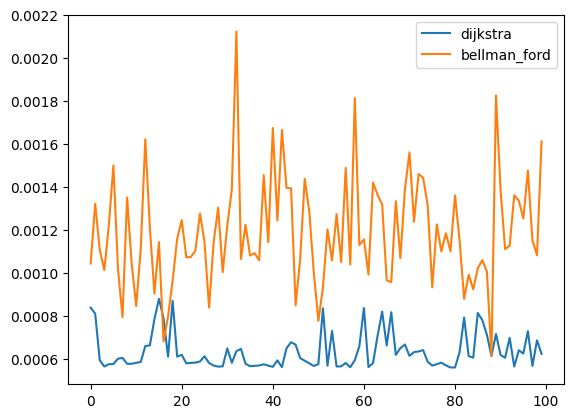

In [15]:
plt.plot(dijkstra_avg_times, label='dijkstra')
plt.plot(bellman_ford_avg_times, label='bellman_ford')
plt.legend(loc='best')

In [16]:
stats.ttest_ind(dijkstra_avg_times, bellman_ford_avg_times)

TtestResult(statistic=np.float64(-20.975792430910058), pvalue=np.float64(3.360992607715944e-52), df=np.float64(198.0))

### SECOND PART

Start: (4, 0), Goal: (6, 19), Path Length: 26


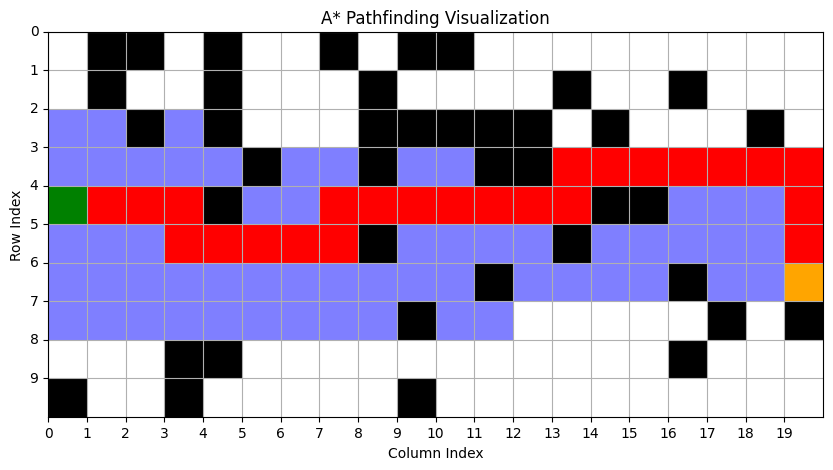

Start: (9, 4), Goal: (4, 7), Path Length: 9


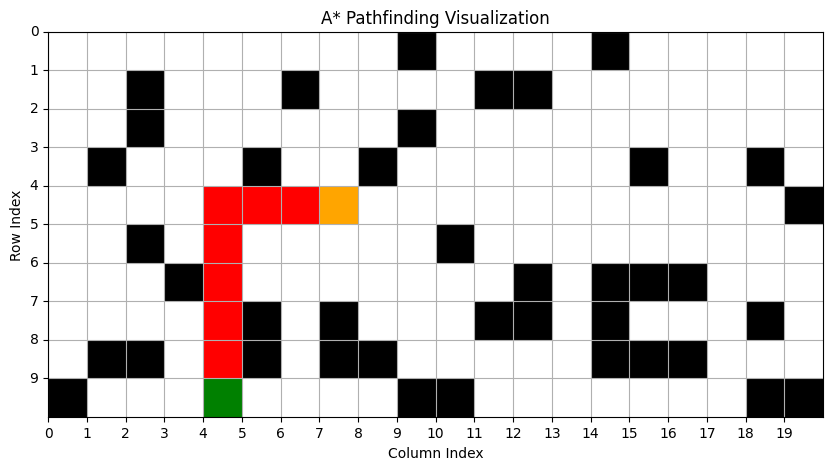

Start: (4, 19), Goal: (8, 0), Path Length: No path


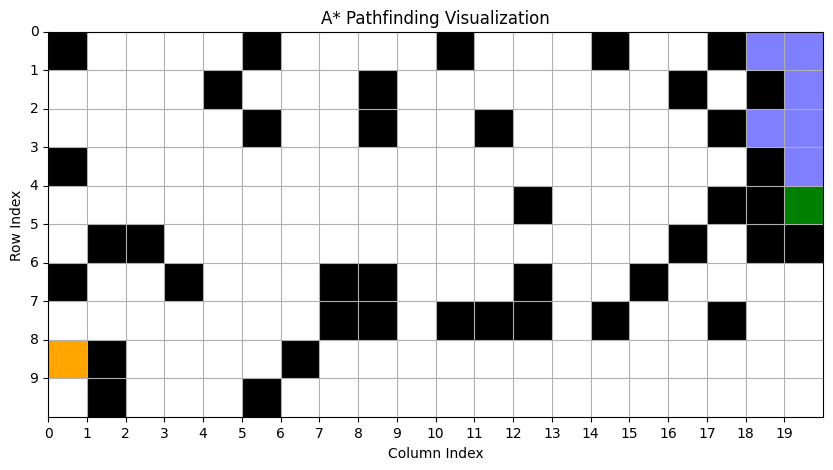

Start: (2, 18), Goal: (5, 0), Path Length: 24


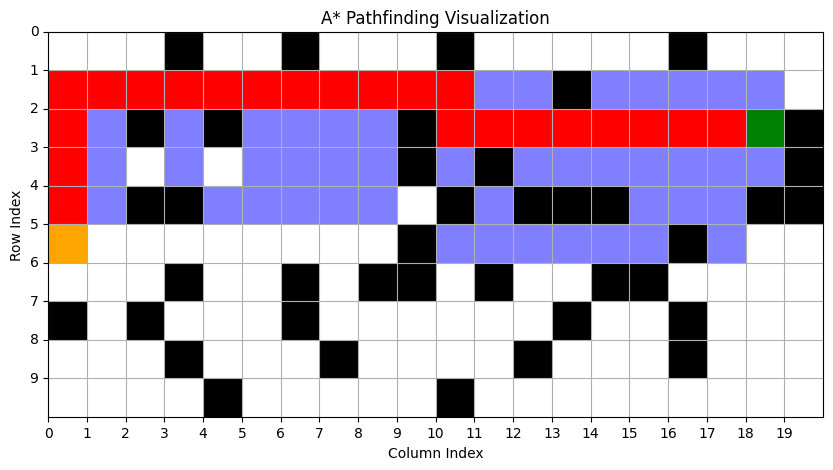

Start: (7, 0), Goal: (1, 16), Path Length: 23


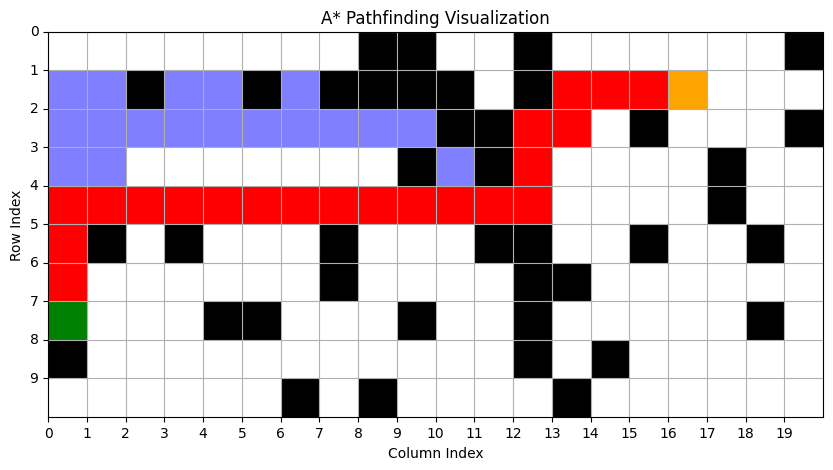

In [17]:
for _ in range(5):
    grid = create_grid(GRID_WIDTH, GRID_HEIGHT, NUM_OBSTACLES)
    non_obstacle_cells = [(i, j) for i in range(GRID_HEIGHT) for j in range(GRID_WIDTH) if grid[i, j] == 0]
    start, goal = random.sample(non_obstacle_cells, 2)

    path, searched_cells = a_star(start, goal, grid)
    print(f"Start: {start}, Goal: {goal}, Path Length: {len(path) if path else 'No path'}")
    plot_grid(grid, path, searched_cells, start, goal)